# Confusion Matrix
https://zhuanlan.zhihu.com/p/46204175

In [1]:
import keras 
import os 
from keras import models, layers
from keras.applications.resnet50 import preprocess_input 
from keras.models import load_model 
import joblib 
import cv2
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
import pandas as pd 
%matplotlib inline 

Using TensorFlow backend.


# Model Definition

In [10]:
class ResNet_SVM:
    '''Implementation of ResNet-SVM. `train_svm.py` should be run before this code.'''
    def __init__(self, backbone, svm_path = 'models/svm/2021-10-25_V100_0.8909808685089584.svm'):
        self.backbone = backbone
        self.svm = joblib.load(svm_path)
    
    def predict(self, batch, preprocess = True):
        '''The data type of input should be ndarray. If it has 3 dimensions, it will be expanded to 4 dimensions.'''
        if preprocess:
            if len(batch.shape)==4:
                batch = [i for i in batch]
            elif len(batch.shape)==3:
                batch = [batch]
            batch_new = [] 
            for img in batch:
                batch_new.append(preprocess_input(img))
            batch = np.array(batch_new)
            
        if len(batch.shape)==3:
            batch = np.expand_dims(batch,axis = 0)
        assert len(batch.shape)==4, "The shape of input should be converted to (N,H,W,C) availably!"
        
        batch = self.backbone.predict(batch)
        batch = self.svm.predict(batch)
        return batch 
            
    def __call__(self, batch, preprocess=True):
        return self.predict(batch, preprocess = preprocess)

def get_model(name='resnet'):
    batch_size = 32 # Tesla 上占用9013MB
    best_model_root = 'models/models_'+str(batch_size)

    model = load_model(os.path.join(best_model_root, 'Best_Model.h5'))
    if name=='resnet-svm':
        for layer in model.layers:
            if isinstance(layer, layers.GlobalAveragePooling2D):
                gap_layer = layer
        model = models.Model(model.inputs, gap_layer.output)
        model = ResNet_SVM(model)
    return model

# Data Preparing

In [3]:
train_path = r'flowers_google'
labels_path = "flowers_label.csv"
ids_path = "flowers_idx.csv"

def PrepareAnnotation(ids_path, labels_path, train_path):
    ids = pd.read_csv(ids_path)
    labels = pd.read_csv(labels_path)

    annotation_dict = {}

    for i in range(len(ids['id'])):
        image_id = ids['id'][i]
        image_lable = ids['flower_cls'][i]
        annotation_dict[image_id] = image_lable

    label_dict = {}
    num_classes = 0

    for i in range(len(labels['flower_class'])):
        label_dict[labels['flower_class'][i]] = labels['label'][i]
        num_classes += 1

    for key, value in annotation_dict.items():
        annotation_dict[key] = label_dict[value]

    image_pathes = []
    targets = []

    for key, value in annotation_dict.items():
        image_name = str(key) + ".jpeg"
        image_path = os.path.join(train_path, image_name)
        image_pathes.append(image_path)
        targets.append(value)

    return image_pathes, targets, num_classes

image_pathes, targets, num_classes = PrepareAnnotation(ids_path, labels_path, train_path)
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(image_pathes, targets, test_size=val_ratio, random_state=42, shuffle = True, stratify = targets)

# Testing Function

In [12]:
def calculate_confusion(model):
    '''Model must have predict function.'''
    x_test = np.array(x_val)
    y_test = np.array(y_val).ravel()
    class_nums = len(set(y_val))
    conf_mat = np.zeros((class_nums, class_nums))
    for label in set(y_val):
        x_cate = x_test[y_test==label]
        y_cate = y_test[y_test==label]
        batch = [] 
        for img_name in x_cate:
            img = cv2.imread(img_name)[...,:3]
            img = img[::-1]
            batch.append(img)
        batch = np.array(batch)
        res = model.predict(batch)
        if not isinstance(model, ResNet_SVM):
            res = np.argmax(res, axis = 1)
        for j in set(y_val):
            conf_mat[label, j] = (res==j).sum()/x_cate.size
    return conf_mat

# Confusion Matrix of ResNet-50

In [6]:
model = get_model()
conf_mat_resnet = calculate_confusion(model)

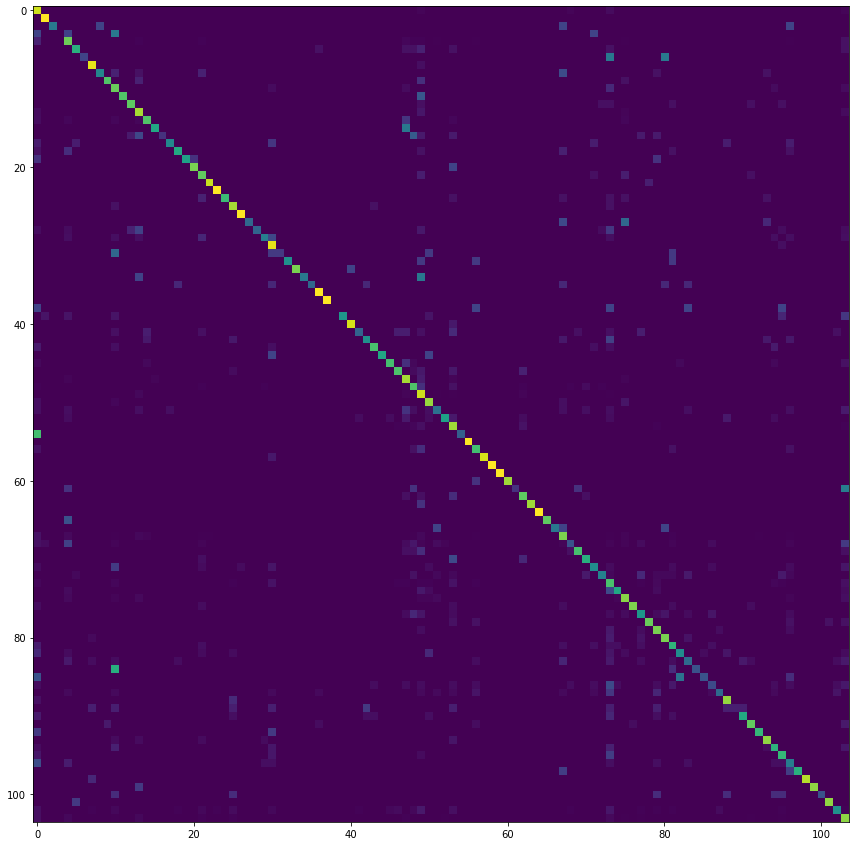

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(conf_mat_resnet)
plt.show()

In [9]:
np.save('data_for_svm/confusion_matrix_resnet',conf_mat_resnet)

# Confusion Matrix of ResNet-SVM

In [13]:
model = get_model(name = 'resnet-svm')
conf_mat_resnet_svm = calculate_confusion(model)

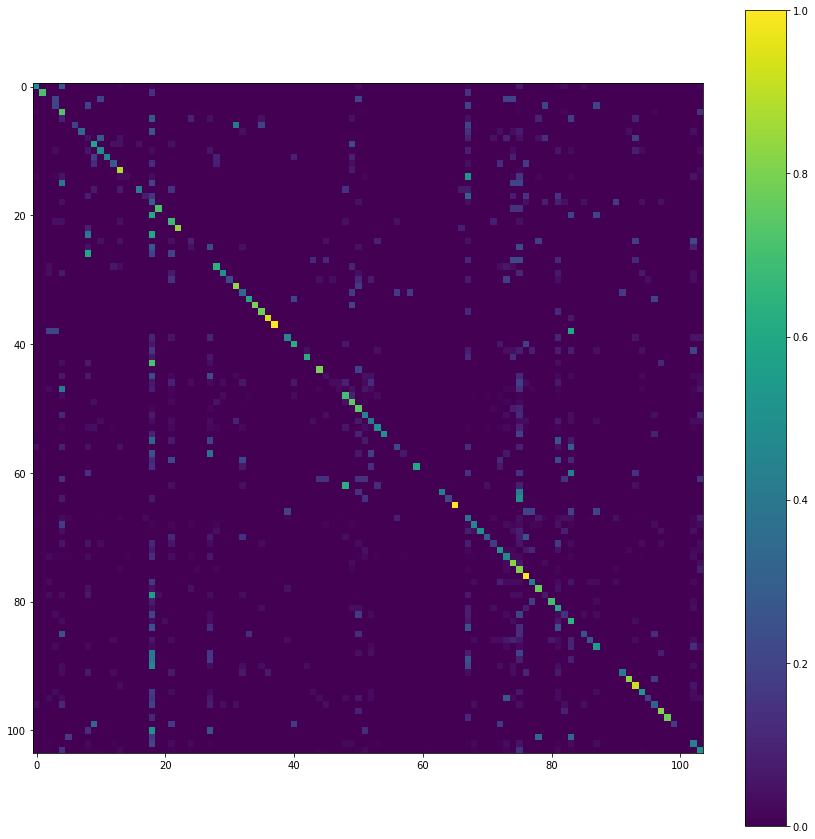

In [14]:
plt.figure(figsize = (15,15))
plt.imshow(conf_mat_resnet_svm)
plt.colorbar()
plt.show()

In [15]:
np.save('data_for_svm/confusion_matrix_resnet-svm',conf_mat_resnet_svm)